# Handy
## Process data

Now that you have your frames recorded (if not, see [gathering data](0_Gather_Data.ipynb)), let's process it.

The most effective way I came up with to recognize different "pose gestures" is probably to calculate angles between specific joints, as shown in the figure below.


![Angles](./angles.png)

In [105]:
# Try to load the data
from os import path 

if not path.exists("result.csv"):
    print("The result.csv file doesn't exist! Please first come through the 0_Gather_Data.ipynb notebook")
    exit(-1)

In [106]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np


df = pd.read_csv("result.csv")

df.head()

,class_name,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,1,0.447791,0.504088,0.119489,0.997393,0.447194,0.502160,0.114871,0.998299,0.447405,...,-0.082802,0.689629,0.378359,0.876665,-0.259851,0.896042,0.411895,0.886828,-0.111868,0.499539
1,1,0.453267,0.496679,0.141106,0.997494,0.452442,0.489988,0.128137,0.998299,0.452023,...,0.232585,0.719998,0.387355,0.807291,-0.044802,0.902926,0.453227,0.775596,0.244320,0.529704
2,1,0.454623,0.492389,0.081777,0.997616,0.453770,0.483505,0.066879,0.998351,0.453135,...,0.279166,0.746815,0.405225,0.759686,0.165465,0.899898,0.456138,0.742445,0.289889,0.552079
3,1,0.455694,0.485707,-0.143536,0.997803,0.456385,0.478311,-0.137859,0.998300,0.457118,...,0.170575,0.761434,0.446523,0.753676,0.168349,0.895916,0.444596,0.768805,0.127956,0.588057
4,1,0.456318,0.481551,-0.127847,0.998014,0.458162,0.474544,-0.120038,0.998437,0.459308,...,0.122029,0.762426,0.455076,0.757013,0.179243,0.897079,0.425721,0.774238,0.078942,0.622115


In [108]:
# Number of data per class
df.groupby("class_name").size()

class_name
0    2000
1     400
2     400
3     400
4     399
5     399
dtype: int64

In [109]:
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid - the angle corner
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(
        a[1] - b[1], a[0] - b[0]
    )
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [110]:
# Function to calculate the values for each individual row

# Each row is a numpy array of shape (33,) with each of its item being a tuple of shape (4,)
def calculate_angle_for_single(class_name, row):
    output_row = [class_name]
    
    # Angle 0
    output_row.append(calculate_angle(row[12], row[14], row[16]))
    
    # Angle 1
    output_row.append(calculate_angle(row[11], row[13], row[15]))

    # Angle 2
    output_row.append(calculate_angle(row[14], row[12], row[24]))

    # Angle 3
    output_row.append(calculate_angle(row[11], row[13], row[23]))

    # # Angle 4
    # output_row.append(calculate_angle(row[12], row[0], row[11]))

    # # Angle 5
    # # This one is a little bit special because the middle point (the corner of the angle) isn't a point itself - it's between 24 and 23
    
    # # The same as angle_5_middle = (((row[24][0] + row[23][0]) / 2), ((row[24][1] + row[23][1]) / 2), ((row[24][2] + row[23][2]) / 2), ((row[24][3] + row[23][3]) / 2))
    # angle_5_middle = [(row[24][i] + row[23][i]) / 2 for i in range(len(row[23]))] 
    # # print(row[24])
    # # print(row[23])
    # # print(angle_5_middle)
    # output_row.append(calculate_angle(row[26], angle_5_middle, row[25]))

    return output_row



    

In [111]:
# Converts the dataframe into:
# 1. class_names dataframe with only 1 column: class_name
# 2. result_array numpy array with each of the values grouped to a tuple, i.e. [(x1, y1, z1, v1), (x2, y2, z2, v2), ...]
# the result_array is of shape (len_data, 33) (but it's (len_data, 33, 4))

result = []
column_names = ['x', 'y', 'z', 'v']

class_names = df["class_name"]
values = df.drop("class_name", axis=1)

columns_per_group = len(column_names)
num_groups = len(values.columns) // columns_per_group

result_array = np.empty((len(values), num_groups), dtype=tuple)
for i in range(num_groups):
    start_idx = i * columns_per_group
    end_idx = (i + 1) * columns_per_group
    result_array[:, i] = [tuple(row[start_idx:end_idx]) for row in df.values]


print(f"shape: {result_array.shape}")
print(f"first row: {result_array[0]}")
print(f"first row first group: {result_array[0][0]}")

shape: (3998, 33)
first row: [(1.0, 0.4477907121181488, 0.5040879845619202, 0.1194894984364509)
 (0.9973932504653932, 0.4471942782402038, 0.5021600723266602, 0.114871360361576)
 (0.9982991814613342, 0.4474047124385834, 0.5019907355308533, 0.1148130074143409)
 (0.9982067346572876, 0.4476267099380493, 0.5019258260726929, 0.114768773317337)
 (0.9984297156333924, 0.447359561920166, 0.5026941895484924, 0.1243534758687019)
 (0.997921884059906, 0.4474142789840698, 0.5028054714202881, 0.1244217529892921)
 (0.9973414540290833, 0.4475260972976684, 0.5029398202896118, 0.1243445500731468)
 (0.9973815083503724, 0.4478784501552582, 0.5050923824310303, 0.096309557557106)
 (0.998552143573761, 0.4489307999610901, 0.5063955187797546, 0.1402899771928787)
 (0.9975435137748718, 0.4478667378425598, 0.5036888718605042, 0.1132747679948806)
 (0.9972656965255736, 0.4480685293674469, 0.5020370483398438, 0.1259273439645767)
 (0.9963538646697998, 0.4457458853721618, 0.5166389346122742, 0.048671331256628)
 (0.99993

In [112]:
# Now that we have the data grouped, calculate the angles (see the picture at the beginning of this notebook)

rows = []
for index, item in enumerate(result_array):
    output = calculate_angle_for_single(class_names.iloc[index], item)
    rows.append(output)

# We calculate 6 angles in total + there's class_name at the start, so create a pandas dataframe with this shape
# Note: for now, using only 4 angles
df = pd.DataFrame(rows, columns=['class_name'] + [f"angle_{i}" for i in range(4)])

print(df.columns)
df.head()

Index(['class_name', 'angle_0', 'angle_1', 'angle_2', 'angle_3'], dtype='object')


,class_name,angle_0,angle_1,angle_2,angle_3
0,1,18.144768,73.230633,93.159998,69.812393
1,1,4.290989,72.174426,99.486092,73.044207
2,1,45.429623,73.413664,98.131603,71.945210
3,1,21.809543,85.160888,96.049364,78.573155
4,1,0.718746,85.305584,94.526247,78.548883


In [113]:
# Save data to csv file
df.to_csv("data.csv", index=None)

<Axes: title={'center': 'Mean Values by Class'}, xlabel='class_name', ylabel='Mean Values'>

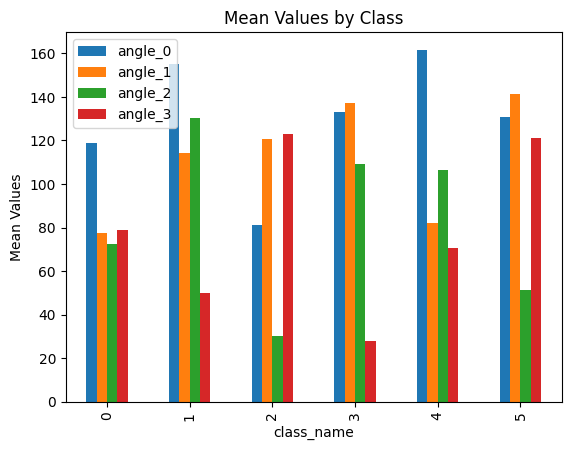

In [114]:
# Group the data by "class_name" and calculate the mean
mean_values = df.groupby('class_name')[
    [f"angle_{angle_index}" for angle_index in range(len(df.columns) - 1)]
].mean()

# Plot the mean values
mean_values.plot(kind='bar', ylabel='Mean Values', title='Mean Values by Class')